<a href="https://colab.research.google.com/github/PieroRendina/MDP-2023-video-object-detection/blob/main/images_similarity_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets -q 

In [9]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of the model checkpoint at nateraw/vit-base-beans were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


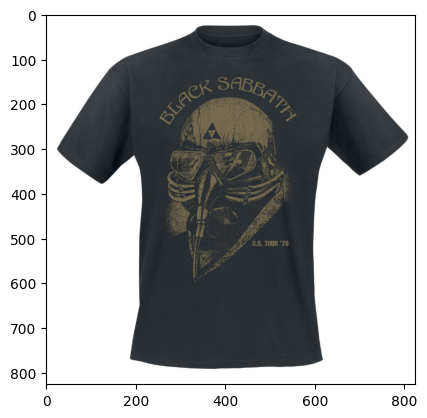

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

ref_image_path = "/content/drive/MyDrive/MDP/Dataset/Product_images/US Tour '78 T-Shirt nero  Black Sabbath.png"

ref_image = Image.open(ref_image_path).convert('RGB')
plt.imshow(ref_image)
plt.show()

In [13]:
import torchvision.transforms as T


# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [12]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()

In [ ]:
import json

movie_json_filepath = "/content/drive/MyDrive/MDP/iron_man_vs_loki.json"


# Open the JSON file
with open(movie_json_filepath, 'r') as file:
    # Load the JSON data
    movie_json = json.load(file)




In [ ]:
# Access the data from the JSON file
movie_json['0']

In [ ]:
import numpy as np

images = []

for key in movie_json.keys():
    for key_inner in movie_json[key].keys():
        image_as_list = movie_json[key][key_inner]['Image']
        img = Image.fromarray(np.array(image_as_list, dtype=np.uint8)).convert()
        print(img.mode)
        images.append(img)


plt.imshow(images[0])

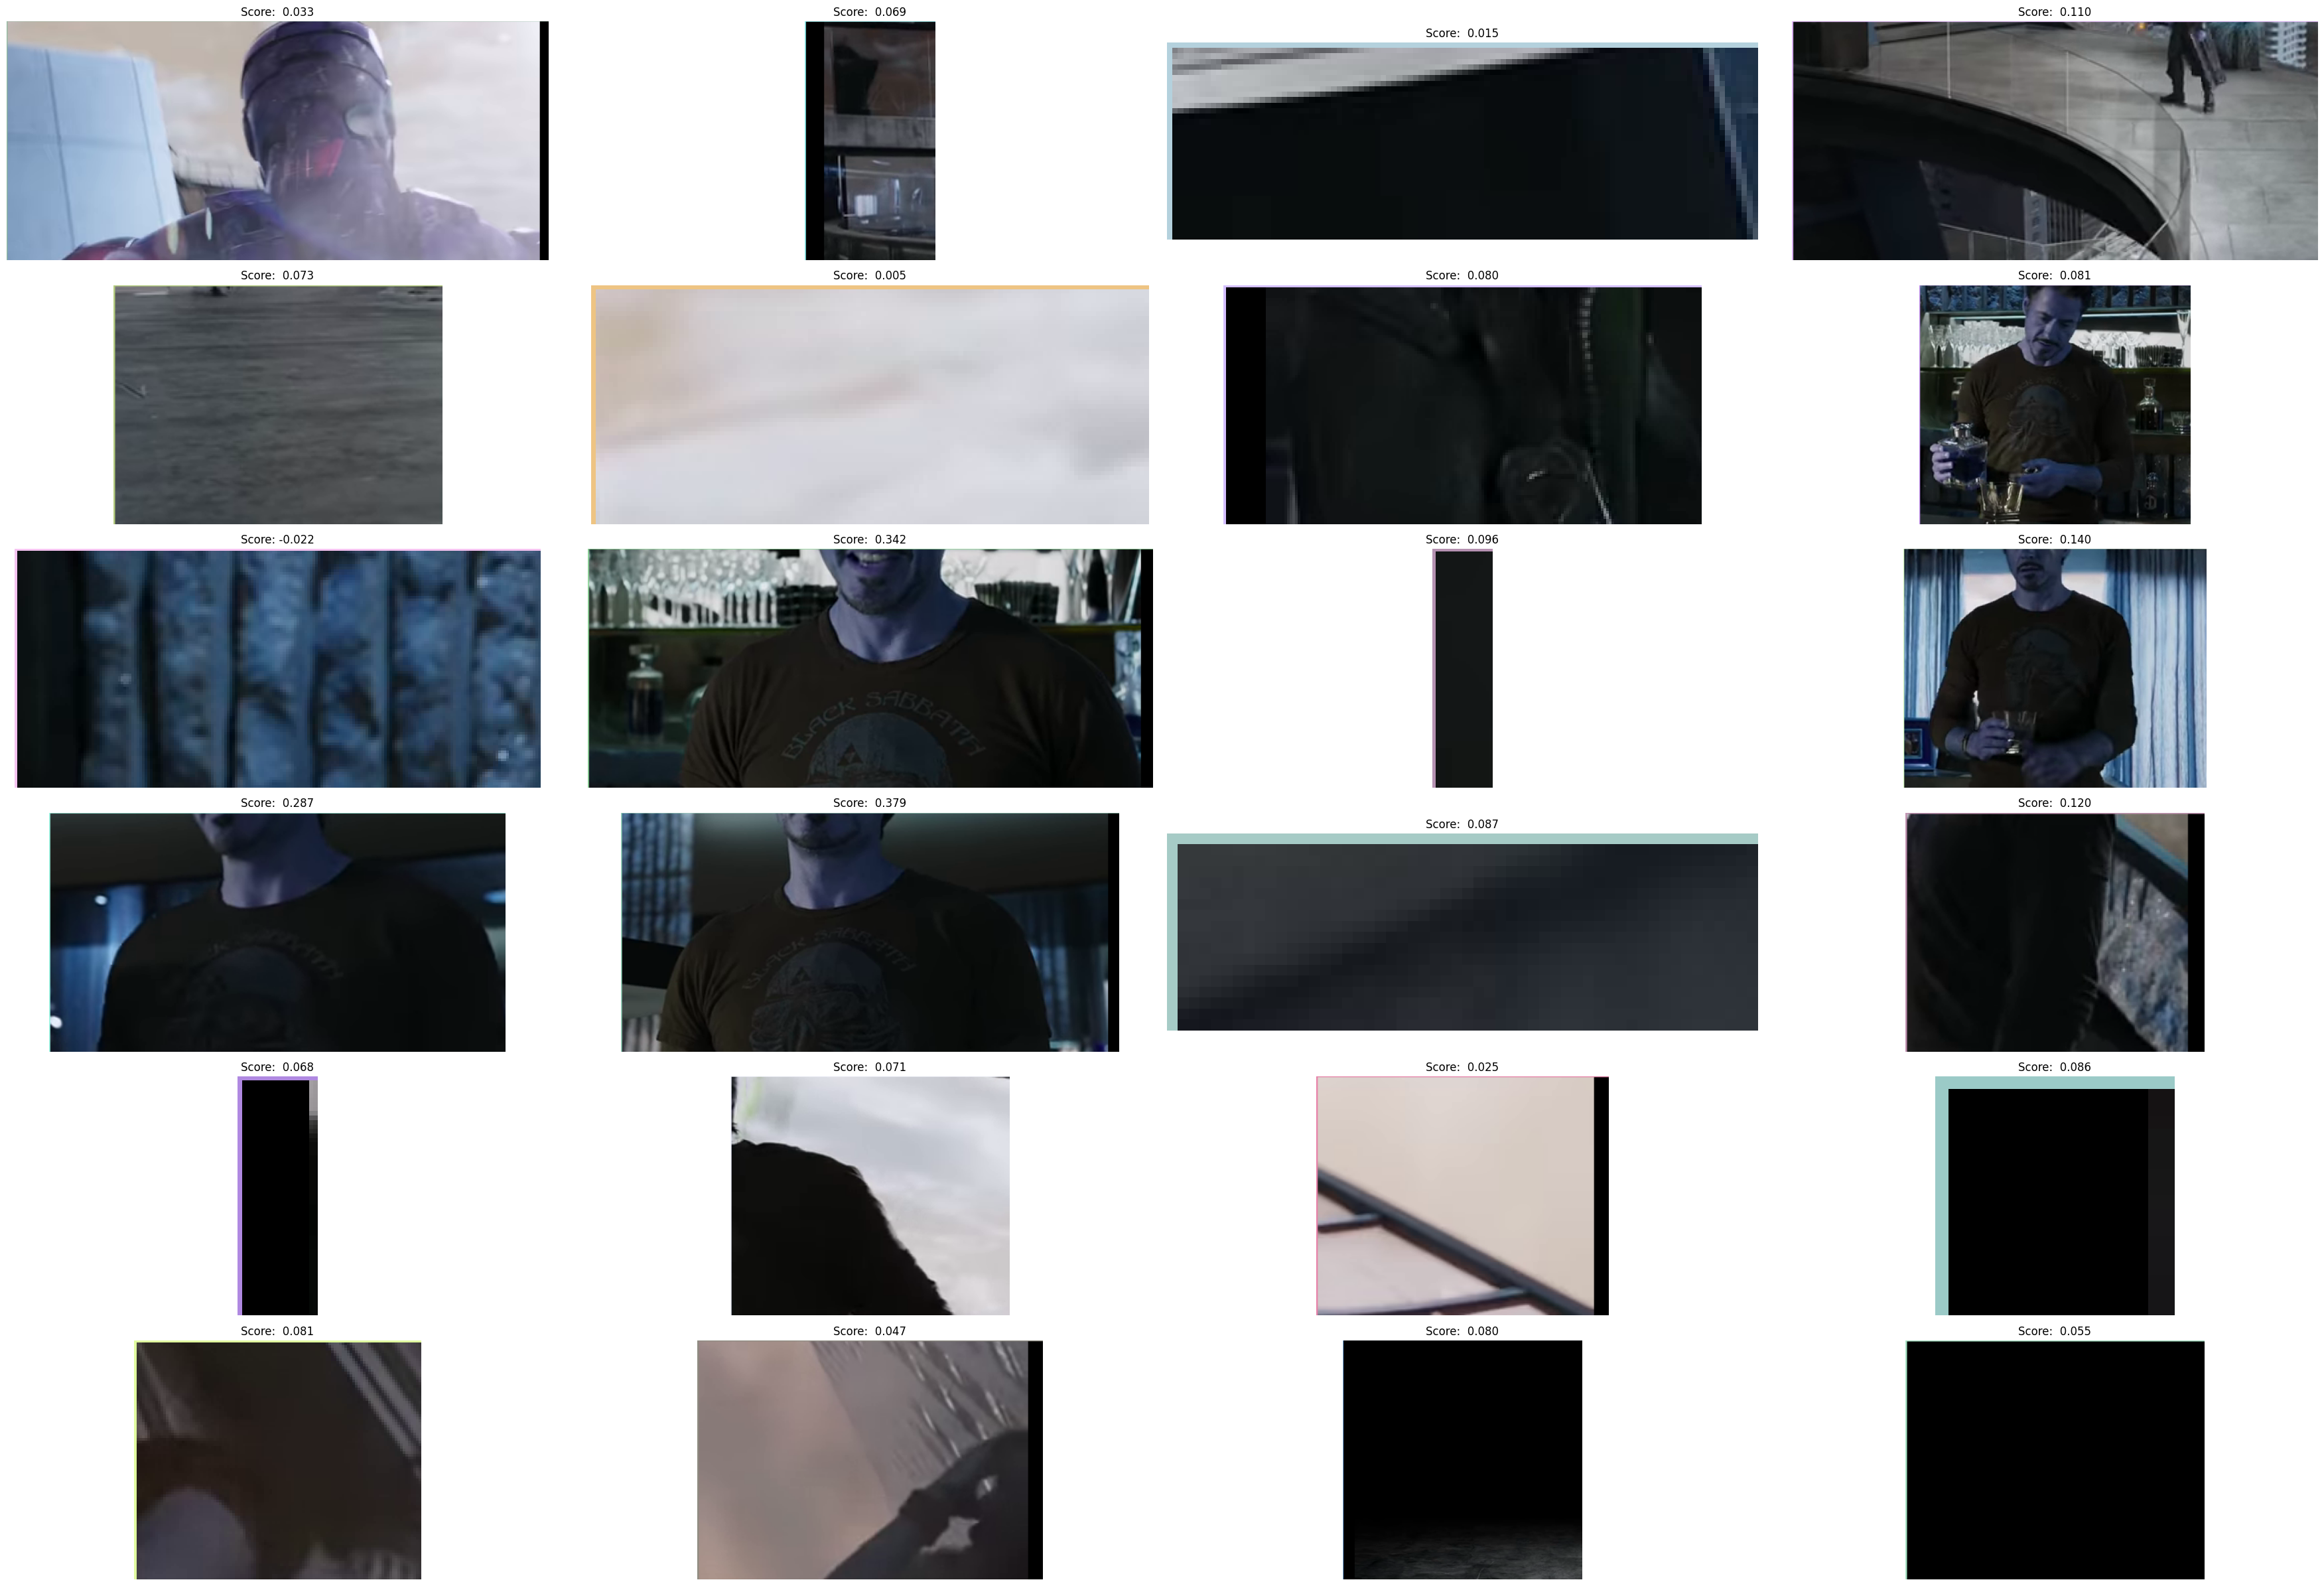

In [100]:
detected_img_path = "/content/drive/MyDrive/MDP/Dataset/image_7_0.png"

#detected_image = Image.open(detected_img_path).convert('RGB')
#plt.imshow(detected_image)

img_ref_transformed = transformation_chain(ref_image)
img_ref_batched = torch.reshape(img_ref_transformed, (1, *img_ref_transformed.shape))



scores = []


# Create a subplot grid dynamically based on the number of images
num_images = len(images)
num_cols = 4  # Number of columns in the grid
num_rows = (num_images + num_cols - 1) // num_cols  # Number of rows in the grid

# Create the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_rows*6, num_cols*6))

# Iterate over the image files and plot the images
for i, image in enumerate(images):
    # Calculate the row and column index of the subplot
    row = i // num_cols
    col = i % num_cols

    img_det_transformed = transformation_chain(image)
    img_det_batched = torch.reshape(img_det_transformed, (1, *img_det_transformed.shape))

    with torch.no_grad():
        embeddings_ref = model(img_ref_batched).last_hidden_state[:, 0].cpu()
        embeddings_det = model(img_det_batched).last_hidden_state[:, 0].cpu()

    score = compute_scores(embeddings_ref, embeddings_det)
    scores.append(score)
    
    # Plot the image in the corresponding subplot
    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Score: {score[0]: .3f}")



# Adjust the spacing between subplots
plt.tight_layout()


# Show the plot
plt.show()